In [1]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import scanpy as sc
from sklearn.decomposition import PCA
from py_pcha import PCHA
import math
import pegasus as pg
from scipy import sparse
import sys
sys.path.append('/home/ngr4/project/scripts/')
import utils
import magic

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")



In [13]:
pdfp = '/home/ngr4/project/scnd/data/processed'
pfp = '/home/ngr4/project/scnd/results/'

adata = utils.load_adata(os.path.join(pdfp,'mouse_200614.h5ad'))

loaded @200617.14:43:33
took 19.10-s to load data


In [15]:
# calculate meld globally
sc.pp.neighbors(adata, n_pcs=100) # don't save and use default neighbors
G = gt.Graph(data=adata.uns['neighbors']['connectivities']+sparse.diags([1]*adata.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
G.knn_max = None

adata.obs['res_t']=5
adata.obs.loc[adata.obs['timepoint']=='12wk', 'res_t'] = 12
adata.obs.loc[adata.obs['timepoint']=='18wk', 'res_t'] = 18
adata.obs.loc[adata.obs['timepoint']=='24wk', 'res_t'] = 24
adata.obs.loc[adata.obs['timepoint']=='30wk', 'res_t'] = 30
adata.obs['ees_t']=meld.MELD().fit_transform(G=G,RES=adata.obs['res_t'])
# adata.obs['ees_sca1']=adata.obs['ees_sca1']-adata.obs['ees_sca1'].mean() # mean center

computing neighbors
    using 'X_pca' with n_pcs = 100


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../conda_envs/rnavel/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished (0:03:11)


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
# cluster genes
random_genes = False
ctype = 'Purkinje cell'
imputed = True

if random_genes:
    genes = adata.var_names.to_list()
    genes = random.sample(random_genes, 10)
else:
    genes = ['Grid2', 'Gria1', 'Grm7', 'Grip2', 'Prkg1', 'Pcdh9', 'Nrxn3', 'Cntn5', 'Lrrc4c', 'Nlgn1', 'Cacna1a', 'Itpr1', 'Cacna1g', 'Trpc3', 'Cacna2d2']#adata.var_names.to_list()
#     genes=[int(sys.argv[1]:int(sys.argv[2]))]

# create dataframe
gdata = pd.DataFrame()
Y = pd.DataFrame()
Y['genotype'] = adata.obs['genotype'].to_list()
Y['Inferred time'] = adata.obs['ees_t'].to_list()
Y['Cell type'] = adata.obs['ctype'].to_list()
if imputed:
    if False:
        # recalculate with G from above 
        imputed_data = pd.DataFrame(adata[:,genes].X.todense(), columns=genes) # note: leon's data lacks imputed data now, can take this and learn imputed data with new knn graph
        magic_op=magic.MAGIC().fit(X=imputed_data,graph=G) # running fit_transform produces wrong shape
        new_imputed = magic_op.transform(imputed_data,genes='all_genes')
        imputed_data = new_imputed
    else:
        imputed_data = new_imputed

    
else:
    imputed_data = pd.DataFrame(adata[:,genes].X.todense(), columns=genes) # note: leon's data lacks imputed data now, can take this and learn imputed data with new knn graph
if False:
    # clear memory
    del adata
tic = time.time()
print('\nAggregating data')
for j,gene in enumerate(genes): 
    if j % 1 == 0:
        iter_left = len(genes) - (j+1)
        p_left=100*(j+1)/len(genes)
        toc = time.time()-tic
        print('  data aggregated for {:.1f}-% genes\tin {:.2f}-s\t~{:.2f}-min remain'.format(p_left,toc,((toc/(j+1))*iter_left)/60))
    X = Y
    X[gene] = imputed_data[gene]
    
    # filter by group
    X = X.loc[X['Cell type']==ctype, :]


    # DREMI-plots
    nbins = 20
    norm = True
    x=X.loc[(X['genotype']=='SCA1'), 'Inferred time']
    y=X.loc[(X['genotype']=='SCA1'), gene]
    H, x_edges, y_edges = np.histogram2d(x, y, 
                                     bins=nbins, density=False,
                                     range=[[np.quantile(x, q=0.0275),
                                             np.quantile(x, q=0.975)],
                                            [0,
                                             np.quantile(y, q=0.99)]])
    if norm:
        H = H / H.sum(axis=0)
        H[np.isnan(H)] = 0

    inf = np.reshape(H,-1)
    
    del H, x, y

    x=X.loc[(X['genotype']=='WT'), 'Inferred time']
    y=X.loc[(X['genotype']=='WT'), gene]
    H, x_edges, y_edges = np.histogram2d(x, y, 
                                     bins=nbins, density=False,
                                     range=[[np.quantile(x, q=0.0275),
                                             np.quantile(x, q=0.975)],
                                            [0,
                                             np.quantile(y, q=0.99)]])
    if norm:
        H = H / H.sum(axis=0)
        H[np.isnan(H)] = 0

    uninf = np.reshape(H,-1)
    
    dt = pd.DataFrame(np.append(inf,uninf))
    dt = dt.T
    dt['gene'] = gene

    gdata = gdata.append(dt, ignore_index=False)
    
    if j % 1000 and False:
        # save every 1000 genes
        gdata.to_csv(os.path.join(pfp,'gdata.csv'))
    
    del X, dt, H, inf, uninf, x, y


Aggregating data
  data aggregated for 6.7-% genes	in 0.00-s	~0.00-min remain
  data aggregated for 13.3-% genes	in 0.08-s	~0.01-min remain
  data aggregated for 20.0-% genes	in 0.13-s	~0.01-min remain
  data aggregated for 26.7-% genes	in 0.17-s	~0.01-min remain


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


  data aggregated for 33.3-% genes	in 0.22-s	~0.01-min remain
  data aggregated for 40.0-% genes	in 0.26-s	~0.01-min remain
  data aggregated for 46.7-% genes	in 0.31-s	~0.01-min remain
  data aggregated for 53.3-% genes	in 0.36-s	~0.01-min remain
  data aggregated for 60.0-% genes	in 0.41-s	~0.00-min remain
  data aggregated for 66.7-% genes	in 0.46-s	~0.00-min remain
  data aggregated for 73.3-% genes	in 0.51-s	~0.00-min remain
  data aggregated for 80.0-% genes	in 0.56-s	~0.00-min remain
  data aggregated for 86.7-% genes	in 0.61-s	~0.00-min remain
  data aggregated for 93.3-% genes	in 0.67-s	~0.00-min remain
  data aggregated for 100.0-% genes	in 0.72-s	~0.00-min remain


In [31]:
gdata = gdata.set_index('gene')

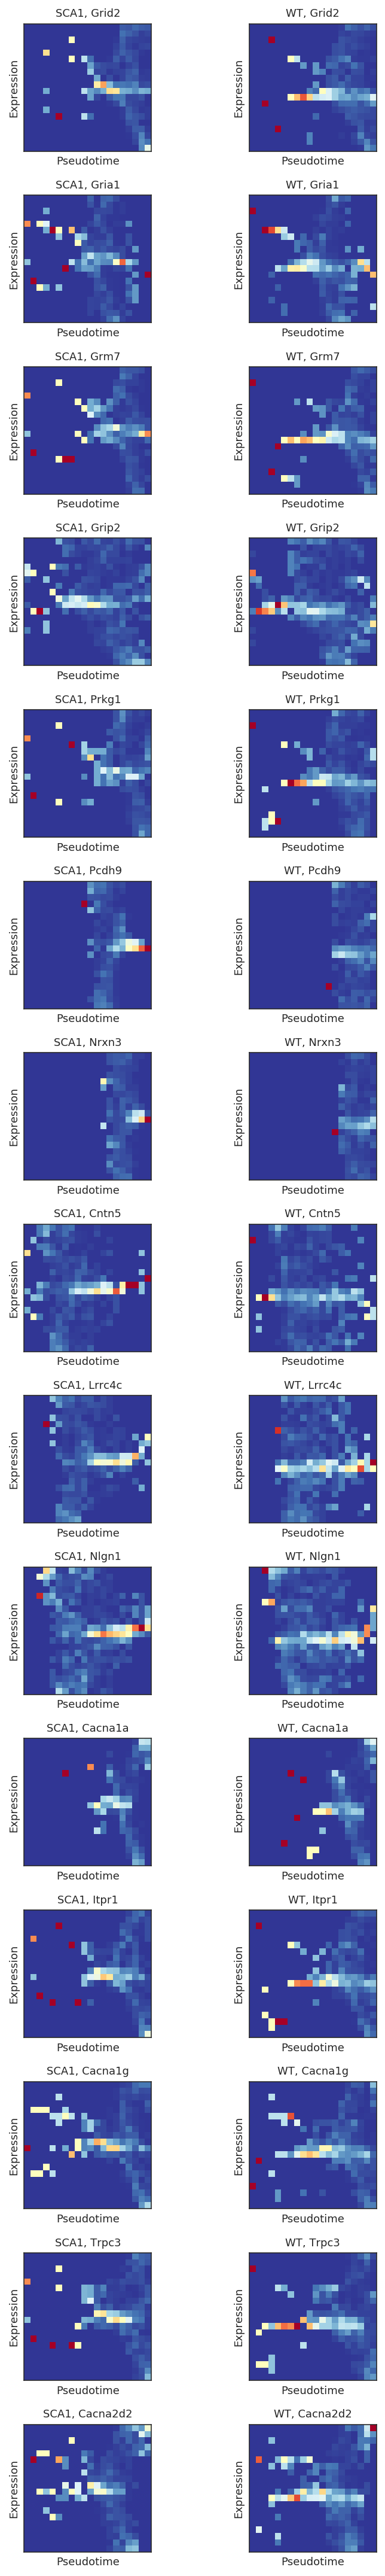

In [32]:
# sanity check
if False:
    # plt random rows
    idx = random.sample(list(range(X.shape[0])), 10)
    x = X[idx, :]
else:
    x = gdata

fig=plt.figure(figsize=(2*3,2*x.shape[0]))
counter = 0
for i in range(x.shape[0]):
    counter += 1
    ax = fig.add_subplot(x.shape[0],2,counter)
    ax.imshow(x.iloc[i,0:400].to_numpy().reshape(20,-1), origin='lower', cmap='RdYlBu_r')
    ax.set_title('SCA1, {}'.format(x.index[i]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Pseudotime')
    ax.set_ylabel('Expression')
    
    counter += 1
    ax = fig.add_subplot(x.shape[0],2,counter)
    ax.imshow(x.iloc[i,400:].to_numpy().reshape(20,-1), origin='lower', cmap='RdYlBu_r')
    ax.set_title('WT, {}'.format(x.index[i]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Pseudotime')
    ax.set_ylabel('Expression')
fig.tight_layout()
fig.savefig(os.path.join(pfp,'gdynamics_goi_imputed.png'),dpi=600, bbox_inches='tight')

In [33]:
genes2plot = {'goi_chk':genes}

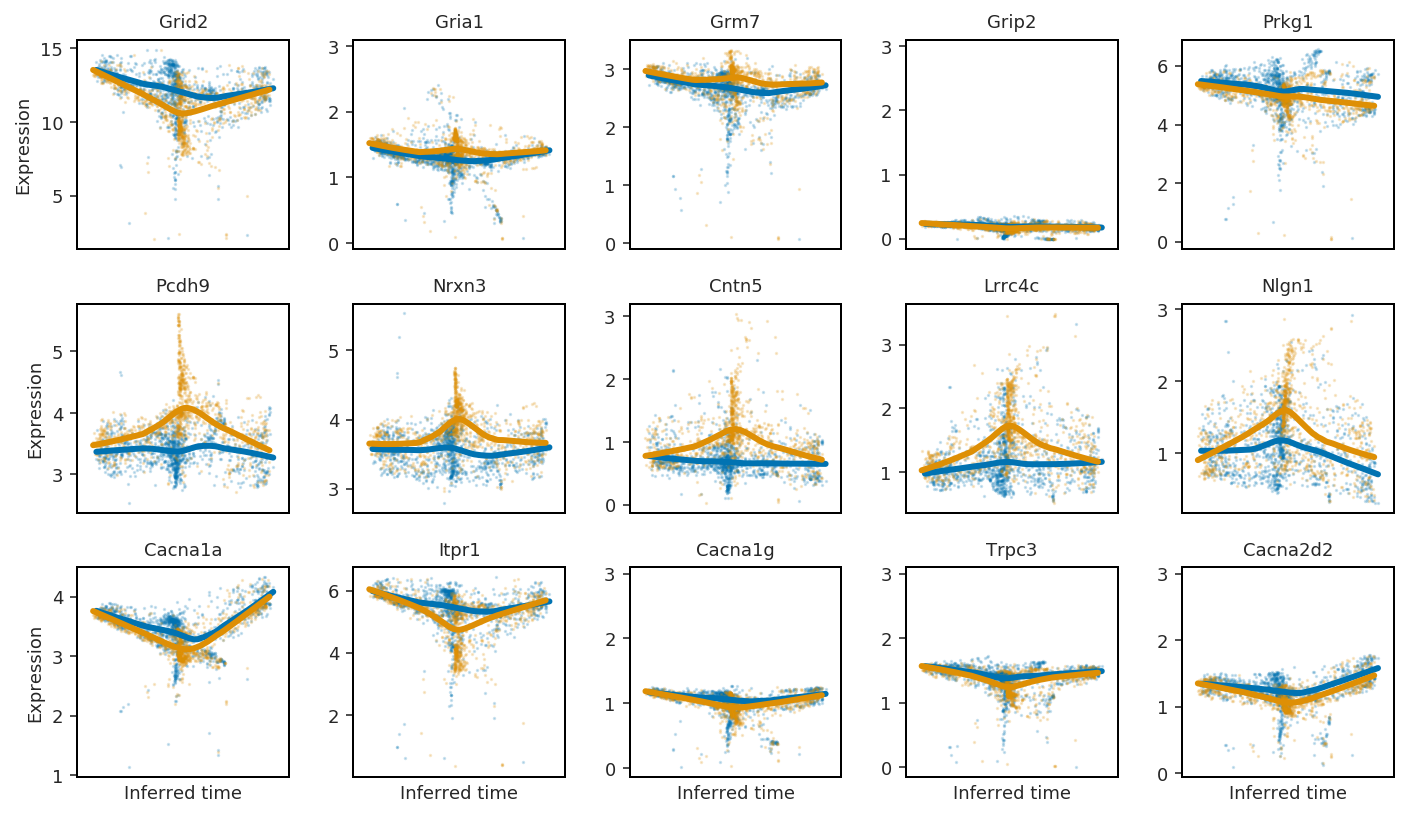

In [34]:
loess = True

for at in genes2plot.keys():
    x = Y
    x[genes2plot[at]] = imputed_data.loc[:, genes2plot[at]]
    
    # filter by group
    x = x.loc[x['Cell type']==ctype, :]
    
    cmap_group={'SCA1':sns.color_palette('colorblind')[1],
                   'WT':sns.color_palette('colorblind')[0]}
    
    if not loess:
        fig = plt.figure(figsize=(2*4,2*np.ceil(len(genes2plot[at])/4)))
        for i,g in enumerate(genes2plot[at]):
            ax = fig.add_subplot(np.ceil(len(genes2plot[at])/4),4,i+1)
            sns.lineplot(
                x='Inferred time',
                y=g,
                hue='genotype',
                size=None,
                style=None,
                data=x,
                palette=cmap_group,
                hue_order=None,
                hue_norm=None,
                sizes=None,
                size_order=None,
                size_norm=None,
                dashes=True,
                markers=None,
                style_order=None,
                units=None,
                estimator='mean',
                ci=None,
                n_boot=1000,
                seed=None,
                sort=True,
                err_style='band',
                err_kws=None,
                legend='brief',
                ax=ax,
                linewidth=1,
            )
            ax.set_title(g)
            if i+1==len(genes2plot[at]):
                ax.legend(bbox_to_anchor=(1,1))
            else:
                ax.legend().set_visible(False)
        fig.tight_layout()
        
    else:
        x = x.melt(
                id_vars=['genotype','Inferred time', 'Cell type'],
                value_vars=genes2plot[at],
                var_name='Gene',
                value_name='Expression',
                col_level=None)
        p = sns.lmplot(
                x='Inferred time',
                y='Expression',
                data=x,
                hue='genotype',
                col='Gene',
                row=None,
                palette=cmap_group,
                col_wrap=5,
                height=2,
                aspect=1,
                markers='o',
                sharex=True,
                sharey=False,
                hue_order=None,
                col_order=None,
                row_order=None,
                legend=False,
                legend_out=True,
                x_estimator=None,
                x_bins=None,
                x_ci='ci',
                scatter=True,
                fit_reg=True,
                ci=None,
                n_boot=1000,
                units=None,
                seed=None,
                order=1,
                logistic=False,
                lowess=True,
                robust=False,
                logx=False,
                x_partial=None,
                y_partial=None,
                truncate=True,
                x_jitter=None,
                y_jitter=None,
                scatter_kws={'s':0.5,'alpha':0.2,'rasterized':True},
                line_kws={'linewidth':3},
                size=None,
            )
        p.set_titles(col_template = '{col_name}')
        p.set(xticks=[])
        for ax in p.axes.flatten(): # Loop directly on the flattened axes 
            for _, spine in ax.spines.items():
                spine.set_visible(True) # You have to first turn them on
                spine.set_color('black')
                spine.set_linewidth(1)
        p.savefig(os.path.join(pfp,'gdynamicsoi_{}_imputed.pdf'.format(at)),bbox_inches='tight',dpi=600)
    # del X